In [60]:
import pandas as pd
import datetime as datetime
import matplotlib.pyplot as plt
import dash
import requests 
import json 

from IPython.display import clear_output
from dash import dcc
from dash import html
from dash.dependencies import Input, Output

In [61]:
pd.set_option('display.max_rows', 500)

# Relative Cases (Absolute Covid Cases/Population Size)

In [62]:
# Requesting the Covid Cases data from our world in data website as a json object.
data_cases=requests.get('https://covid.ourworldindata.org/data/owid-covid-data.json')

# Requesting the vaccination data from our world in data website as a json object:
data_Vax=requests.get('https://github.com/owid/covid-19-data/raw/master/public/data/vaccinations/vaccinations.json')


In [63]:
# load json object for the total number of COVID cases 
json_object_cases=json.loads(data_cases.content)

#Dumping all data from json into a variable:
json_object_vax=json.loads(data_Vax.content)

In [80]:
country_list = [
    'AUS',
    'USA',
    'ESP',
    'IND',
    'CHN',
    'DEU'
]
dict_country={}
# output=pd.DataFrame()
for each in country_list:
    cases_country_data = json_object_cases[each]['data'][:]
    dict_country['list_date_'+each]=[]
    dict_country['list_cases_'+each]=[]
    for index in range(len(cases_country_data)):
        # Obtaining the dates from the json dictionary
        list_date = json_object_cases[each]['data'][index]
        # append the dates to the date list
        dict_country['list_date_'+each].append(list_date['date'])

        # Get the total population for australia
        pop=json_object_cases[each]['population']
        
        list_cases = json_object_cases[each]['data'][index]
        dict_country['list_cases_'+each].append(list_cases['total_cases']/pop)
        
df = pd.DataFrame.from_dict(dict_country,orient='index').transpose()


for each in country_list:
    df['list_date_'+each] = pd.to_datetime(df['list_date_'+each],format='%Y-%m-%d')
df.head()

,list_date_AUS,list_cases_AUS,list_date_USA,list_cases_USA,list_date_ESP,list_cases_ESP,list_date_IND,list_cases_IND,list_date_CHN,list_cases_CHN,list_date_DEU,list_cases_DEU
0,2020-01-26,1.54315e-07,2020-01-22,2.96738e-09,2020-02-01,2.10584e-08,2020-01-30,7.10447e-10,2020-01-22,3.83619e-07,2020-01-27,1.19892e-08
1,2020-01-27,1.92893e-07,2020-01-23,2.96738e-09,2020-02-02,2.10584e-08,2020-01-31,7.10447e-10,2020-01-23,4.4814e-07,2020-01-28,4.79567e-08
2,2020-01-28,1.92893e-07,2020-01-24,5.93476e-09,2020-02-03,2.10584e-08,2020-02-01,7.10447e-10,2020-01-24,6.42404e-07,2020-01-29,4.79567e-08
3,2020-01-29,2.31472e-07,2020-01-25,5.93476e-09,2020-02-04,2.10584e-08,2020-02-02,1.42089e-09,2020-01-25,9.81139e-07,2020-01-30,4.79567e-08
4,2020-01-30,3.47208e-07,2020-01-26,1.48369e-08,2020-02-05,2.10584e-08,2020-02-03,2.13134e-09,2020-01-26,1.44611e-06,2020-01-31,5.99459e-08


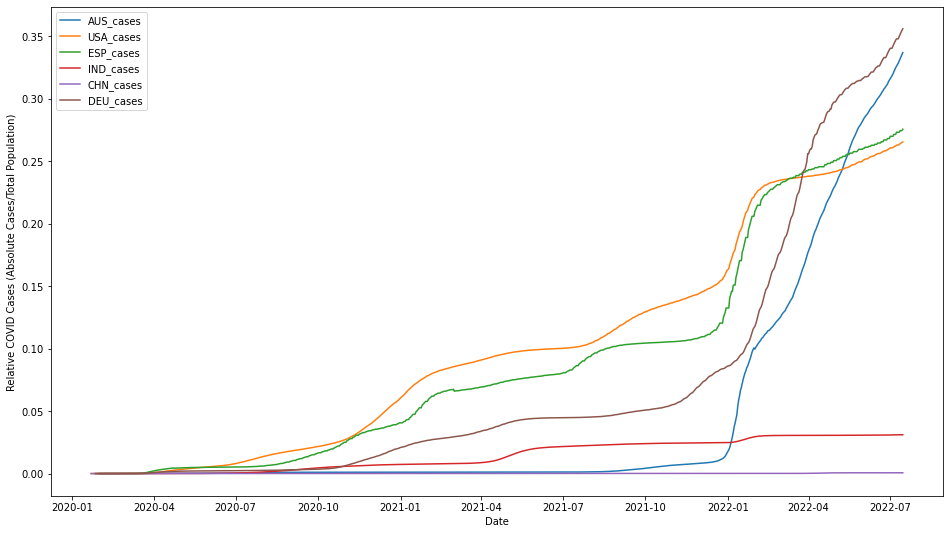

In [81]:
# Defining the size for plotting 
fig = plt.figure(figsize=(16,9))
for each in country_list:
    clear_output(wait=True)
    plt.plot(df['list_date_'+each], df['list_cases_'+each], label = each+"_cases")
    
# Add X-label for date
plt.xlabel('Date')
# Add Y-label for relative covid cases 
plt.ylabel('Relative COVID Cases (Absolute Cases/Total Population)')
# Add legend
plt.legend()
# Display Plot
plt.show()

# Relative Vaccinations (Absolute Vaccination/Population Size)

In [155]:
# create an empty dictionary
dict_from_list = {}

# for loop to convert list of dict
# to dict of list
for item in json_object_vax:
	name = item['iso_code']
	dict_from_list[name] = item

dict_data={}

for each in country_list:
	#Separating dictonary of USA from list and adding it to new list:
	country_data =dict_from_list[each]
	dict_data['country_'+each]=[]
	#Separating the list that contains the data we need from the USA dictonary:
	dict_data['country_'+each] =dict_from_list[each]['data']

	#Creating an empty dictonary to get data(date, vaccination):
	dictionary_date_vax={}

	#Creating dictonary from the list:
	for item in country_data:
		name = item['date']
		dictionary_date_vax[each][name] = item
	print(dictionary_date_vax['AUS'])
	# #Creating an empty list:
	# inter_list_USA=[]

	# #Adding all the keys from data dictonary to an empty list:
	# for key in dictionary_of_USA_date_vax:
	# 	inter_list_USA.append(dictionary_of_USA_date_vax[key])


	# #Converting list to dataframe:
	# pd_USA_inter=pd.DataFrame(inter_list_USA)

	# #Renaming the label total_vaccinations column to 'USA ratio vaccination:population' (data it holds while plotting)
	# pd_USA_inter = pd_USA_inter.rename(columns={'total_vaccinations':'USA_ratio_vax_pop'})

	# #Setting the index of the dataframe to date:
	# pd_USA_inter.set_index('date')

	# #Separating the data columns that we need for the plot (date, total_vaccinations):
	# pd_USA_fin= pd_USA_inter.iloc[:, [0,1]]

	# # Get the total population for australia
	# pop=json_object_cases[each]['population']

	# #Dividing the vaccinated people by total population to get the ratio:
	# fin_USA=pd_USA_fin.copy()
	# fin_USA['USA_ratio_vax_pop']=fin_USA['USA_ratio_vax_pop'].div(pop)



TypeError: string indices must be integers

In [ ]:
# Defining the size for plotting 
fig = plt.figure(figsize=(16,9))
for each in country_list:
    clear_output(wait=True)
    plt.plot(df['list_date_'+each], df['list_cases_'+each], label = each+"_cases")
    
# Add X-label for date
plt.xlabel('Date')
# Add Y-label for relative covid cases 
plt.ylabel('Relative Vaccination(Total Vaccination/Total Population)')
# Add legend
plt.legend()
# Display Plot
plt.show()

In [9]:
# create an empty dictionary
dict_from_list = {}

# for loop to convert list of dict
# to dict of list
for item in json_object_vax:
	name = item['country']
	dict_from_list[name] = item

#Separating dictonary of USA from list and adding it to new list:
country_USA=dict_from_list['United States']

#Separating the list that contains the data we need from the USA dictonary:
country_USA_data=country_USA['data']

#Creating an empty dictonary to get data(date, vaccination):
dictionary_of_USA_date_vax={}

#Creating dictonary from the list:
for item in country_USA_data:
	name = item['date']
	dictionary_of_USA_date_vax[name] = item

#Creating an empty list:
inter_list_USA=[]

#Adding all the keys from data dictonary to an empty list:
for key in dictionary_of_USA_date_vax:
	inter_list_USA.append(dictionary_of_USA_date_vax[key])


#Converting list to dataframe:
pd_USA_inter=pd.DataFrame(inter_list_USA)

#Renaming the label total_vaccinations column to 'USA ratio vaccination:population' (data it holds while plotting)
pd_USA_inter = pd_USA_inter.rename(columns={'total_vaccinations':'USA_ratio_vax_pop'})

#Setting the index of the dataframe to date:
pd_USA_inter.set_index('date')

#Separating the data columns that we need for the plot (date, total_vaccinations):
pd_USA_fin= pd_USA_inter.iloc[:, [0,1]]

#Getting the total population of United Kingdom from the above requested json data:
pop_USA=json_object_cases['USA']['population']

#Dividing the vaccinated people by total population to get the ratio:
fin_USA=pd_USA_fin.copy()
fin_USA['USA_ratio_vax_pop']=fin_USA['USA_ratio_vax_pop'].div(pop_USA)

# Dashboard Creation 

In [73]:
app = dash.Dash()
app.layout = html.Div([
    html.Label('Multi-Select Country'),
    dcc.Dropdown(id='country_drop_down',
                 options=[{
                     'label': 'Australia',
                     'value': 'AUS'
                 }, {
                     'label': 'USA',
                     'value': 'USA'
                 }, {
                     'label': 'Spain',
                     'value': 'ESP'
                 }, {
                     'label': 'India',
                     'value': 'IND'
                 }, {
                     'label': 'China',
                     'value': 'CHN'
                 }, {
                     'label': 'Germany',
                     'value': 'DEU'
                 }],
                 
                 value=['USA', 'IND'],
                 multi=True),
    dcc.Graph(figure=fig, id='main_window_slope')
])

In [57]:
@app.callback(Output('main_window_slope', 'figure'),
              [Input('country_drop_down', 'value')])


def update_figure(country_list):

    # Defining the size for plotting 
    fig = plt.figure(figsize=(16,9))
    
    for each in country_list:
        clear_output(wait=True)
        plt.plot(df['list_date_'+each], df['list_cases_'+each], label = each+"_cases")
        
    # Add X-label for date
    plt.xlabel('Date')
    # Add Y-label for relative covid cases 
    plt.ylabel('Relative COVID Cases (Absolute Cases/Total Population)')
    # Add legend
    plt.legend()
    # Display Plot
    plt.show()

In [79]:

@app.callback(Output('main_window_slope', 'figure'),
              [Input('country_drop_down', 'value')])
def update_figure(country_list):

    traces = []
    for each in country_list:
        traces.append(
            dict(x=df['list_date_'+each],
                 y=df['list_cases_'+each],
                 mode='markers+lines',
                 opacity=0.9,
                 line_width=2,
                 marker_size=1,
                 name=each))
  
    return {
        'data':
        traces,
        'layout':
        dict(
            width=1280,
            height=720,
            xaxis_title='Time',
            yaxis_title=
            'Confirmed infected people (source johns hopkins case, log-scale)',
            xaxis={
                'tickangle': -45,
                'nticks': 20,
                'tickfont': dict(size=14, color='#7f7f7f'),
            },
            yaxis={
                'type': 'log',
                'range': '[1.1, 5.5]'
            })
    }

[{'x': 0     2020-01-26
  1     2020-01-27
  2     2020-01-28
  3     2020-01-29
  4     2020-01-30
           ...    
  901   2022-07-15
  902          NaT
  903          NaT
  904          NaT
  905          NaT
  Name: list_date_AUS, Length: 906, dtype: datetime64[ns],
  'y': 0      1.54315e-07
  1      1.92893e-07
  2      1.92893e-07
  3      2.31472e-07
  4      3.47208e-07
            ...     
  901       0.336968
  902           None
  903           None
  904           None
  905           None
  Name: list_cases_AUS, Length: 906, dtype: object,
  'mode': 'markers+lines',
  'opacity': 0.9,
  'line_width': 2,
  'marker_size': 1,
  'name': 'AUS'},
 {'x': 0     2020-01-22
  1     2020-01-23
  2     2020-01-24
  3     2020-01-25
  4     2020-01-26
           ...    
  901   2022-07-11
  902   2022-07-12
  903   2022-07-13
  904   2022-07-14
  905   2022-07-15
  Name: list_date_USA, Length: 906, dtype: datetime64[ns],
  'y': 0      2.96738e-09
  1      2.96738e-09
  2      5.93476e

In [70]:
app.run_server(debug=True, use_reloader=False)

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: on
